# Perspectives on Utilization of Measurements in Quantum Algorithms

## Valter Uotila, Ilmo Salmenperä, Leo Becker, Arianne Meijer-van de Griend, Aakash Ravindra Shinde and Jukka K. Nurminen

<center>
<img src="https://upload.wikimedia.org/wikipedia/en/thumb/8/84/University_of_Helsinki.svg/1280px-University_of_Helsinki.svg.png" alt="HY-logo" width="500" height="500">
</center>

## Outline of this presentation

### The central component of this presentation is quantum software and code which are instances and examples of points that we make in the paper

1. Introduction and motivation
2. Categories for measurement operations
   1. Measure the whole state (Code demo: Recovering the density matrix)
   2. Modify the state by measurements (Code demo: Toffoli gate teleportation)
   3. Measurements as solutions to quantum computational challenges
3. Conclusion

## Introduction

| **Measurement theory**     | **Properties**                                                                                                                                         | **Quantum states** | **Properties**                                                                                      |
|---------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------|------------------------------------------------------------------------------------------------------|
| **PVM measurements**      | Idempotent: $P_i^2 = P_i$  <br> Orthogonality: $P_i P_j = \delta_{ij}P_i$ <br> Completeness: $\sum_i P_i = I$                                            | **Pure states**    | Idempotent: $\rho^2 = \rho$ <br> Projection onto 1D subspace <br> Normalization: $\text{Tr}(\rho) = 1$ |
| **POVM measurements**     | Positive operators $E_i \geq 0$ <br> Completeness: $\sum_i E_i = I$ <br> Not necessarily orthogonal <br> Generalization of PVMs                          | **Mixed states**   | Positive operators $\rho \geq 0$ <br> Normalization: $\text{Tr}(\rho) = 1$ <br> Not necessarily pure <br> Generalization of pure states |

## Motivation

1. There are no previous works which would survey the role of measurements in practical quantum algorithms
2. While this is a relatively short survey, we use three high level categories for how measurements are used in quantum algorithms
    1. Measure the whole state (Code demo: Recovering the density matrix)
    2. Modify the state by measurements (Code demo: Toffoli gate teleportation)
    3. Measurements as solutions to quantum computational challenges

## Category 1: Measure the whole state

### Demonstration on Informationally Complete Positive-Valued Operator Measures (IC-POVM)

Consider the following set of POVMs
\begin{align}
    E_{+z} &= p_z |0\rangle\langle0|, &\quad E_{-z} &= p_z |1\rangle\langle1|, \\
    E_{\pm x} &= p_x | \pm \rangle \langle \pm |, &\quad E_{\pm y} &= p_y | \pm i \rangle \langle \pm i |,
\end{align}
where $p_{z}, p_{x}, p_{y} \in [0, 1]$ so that $p_{z} + p_{x} + p_{y} = 1$.

The reconstruction of the state is done with so-called dual operators, which are given by
\begin{align}
    D_{\pm \alpha} = \frac{I \pm \sigma_{\alpha}/p_{\alpha}}{2},
\end{align}
where $\sigma_{\alpha}$ is the corresponding Pauli matrix, $p_{\alpha}$ is the probability and $\alpha \in \left\{x, y, z \right\}$.

With the dual operators, the reconstructed state $\rho$ has the following form
\begin{align}
    \rho = \sum_{k \in I} \mathrm{Tr}(\rho E_k) D_k.
\end{align}

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 8]

from qiskit_aer import Aer
from qiskit_ibm_runtime.fake_provider import FakeManilaV2

backend = Aer.get_backend('statevector_simulator') 
#backend = FakeManilaV2()

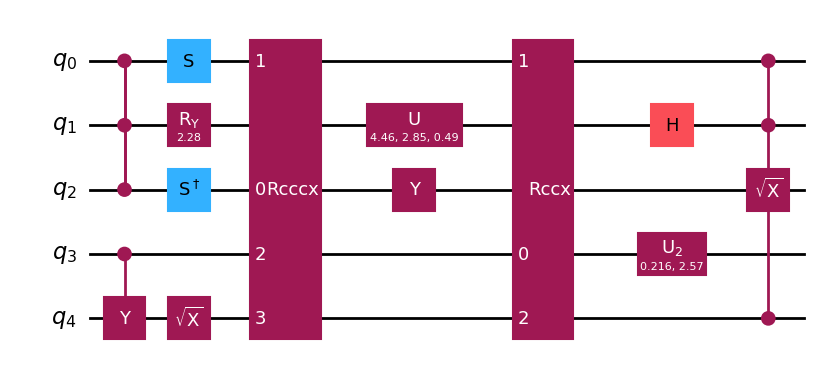

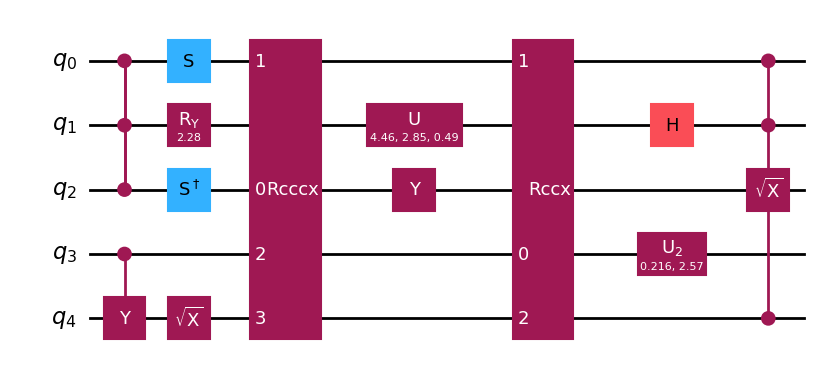

In [2]:
from qiskit.circuit.random import random_circuit

n_qubits = 5
circuit = random_circuit(n_qubits, 5, measure=False)
circuit.draw(output='mpl')

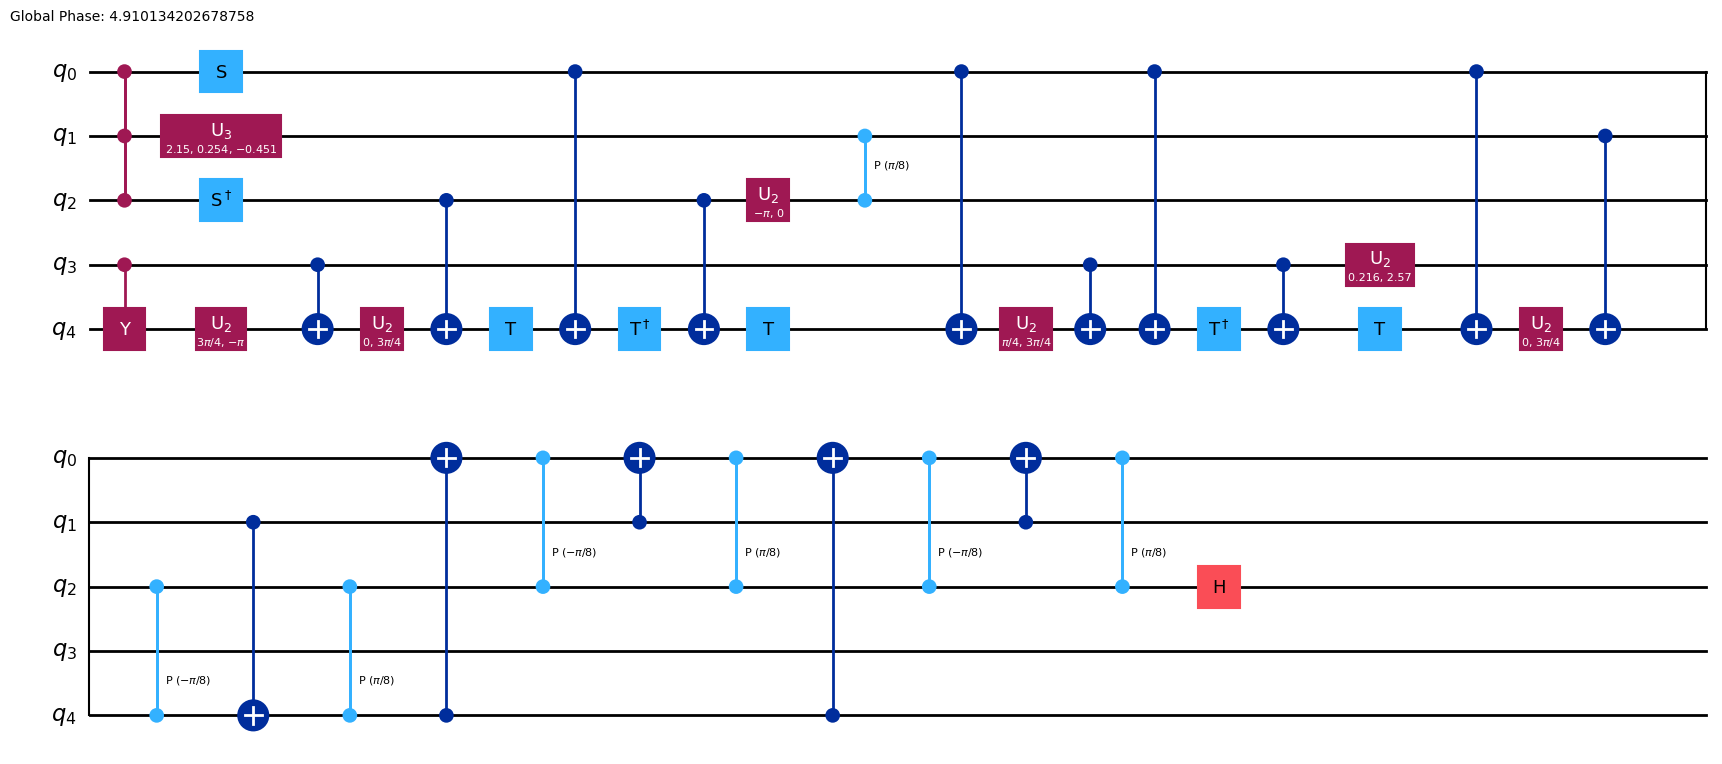

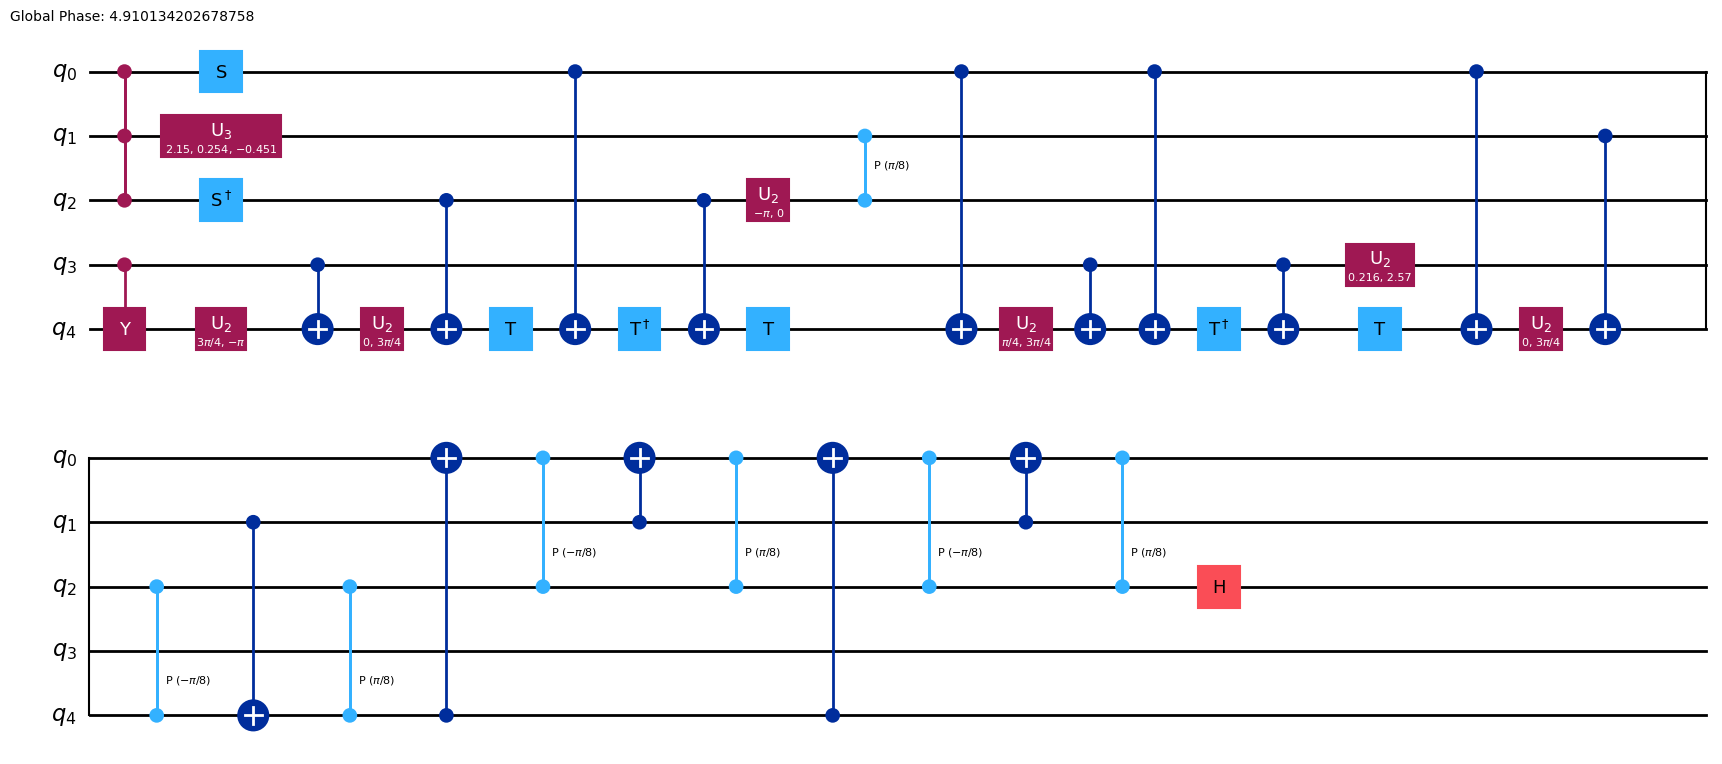

In [3]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pass_manager = generate_preset_pass_manager(backend=backend, optimization_level=1)
transpiled_circuit = pass_manager.run(circuit)
transpiled_circuit.draw(output='mpl')

In [4]:
from povm_toolbox.sampler import POVMSampler 
from povm_toolbox.library import ClassicalShadows
from povm_toolbox.post_processor import POVMPostProcessor

from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(mode=backend)
povm_sampler = POVMSampler(sampler=sampler)
measurement = ClassicalShadows(num_qubits=n_qubits, seed=0)

shots = 2000

job = povm_sampler.run([circuit], shots=shots, povm=measurement, pass_manager=pass_manager)
pub_result = job.result()[0]
counts = pub_result.get_counts()

observable = SparsePauliOp.from_list([("ZIIII", 1), ("IZIII", 1), ("IIZII", 1), ("IIIZI", 1), ("IIIIZ", 1)])

post_processor = POVMPostProcessor(pub_result)
exp_value, std= post_processor.get_expectation_value(observable)
print("Noisy expectation value: ", exp_value)

Noisy expectation value:  -0.5145


In [5]:
from qiskit.quantum_info import Statevector, SparsePauliOp

statevector = Statevector.from_instruction(circuit)

# Compute the exact expectation value
expectation_value = statevector.expectation_value(observable)
print("Expectation value:", expectation_value.real)

Expectation value: -0.5438046809369943


In [6]:
probabilities = {}
for res, count in counts.items():
   c = tuple((int(r) for r in res))
   probabilities[c] = count / shots

In [7]:
from qiskit.quantum_info import Operator, DensityMatrix
from functools import reduce
import operator

density_matrix = None

for state, prob in probabilities.items():
    duals = [post_processor.dual[(qubit_id,)].operators[povm_id] for qubit_id, povm_id in enumerate(reversed(state))]
    
    # Convert to Operators
    dual_operators = [Operator(dual) for dual in duals]
    
    # Compute tensor product using reduce
    tensor_product_op = reduce(lambda a, b: a.tensor(b), dual_operators)
    
    # Scale and accumulate
    if density_matrix is None:
        density_matrix = prob * tensor_product_op
    else:
        density_matrix = density_matrix + prob * tensor_product_op

density_matrix = DensityMatrix(density_matrix.data)

# Compute expectation value
expectation_value = density_matrix.expectation_value(observable)
print(f"Expectation value: {expectation_value.real}")

Expectation value: -0.5144999999999944


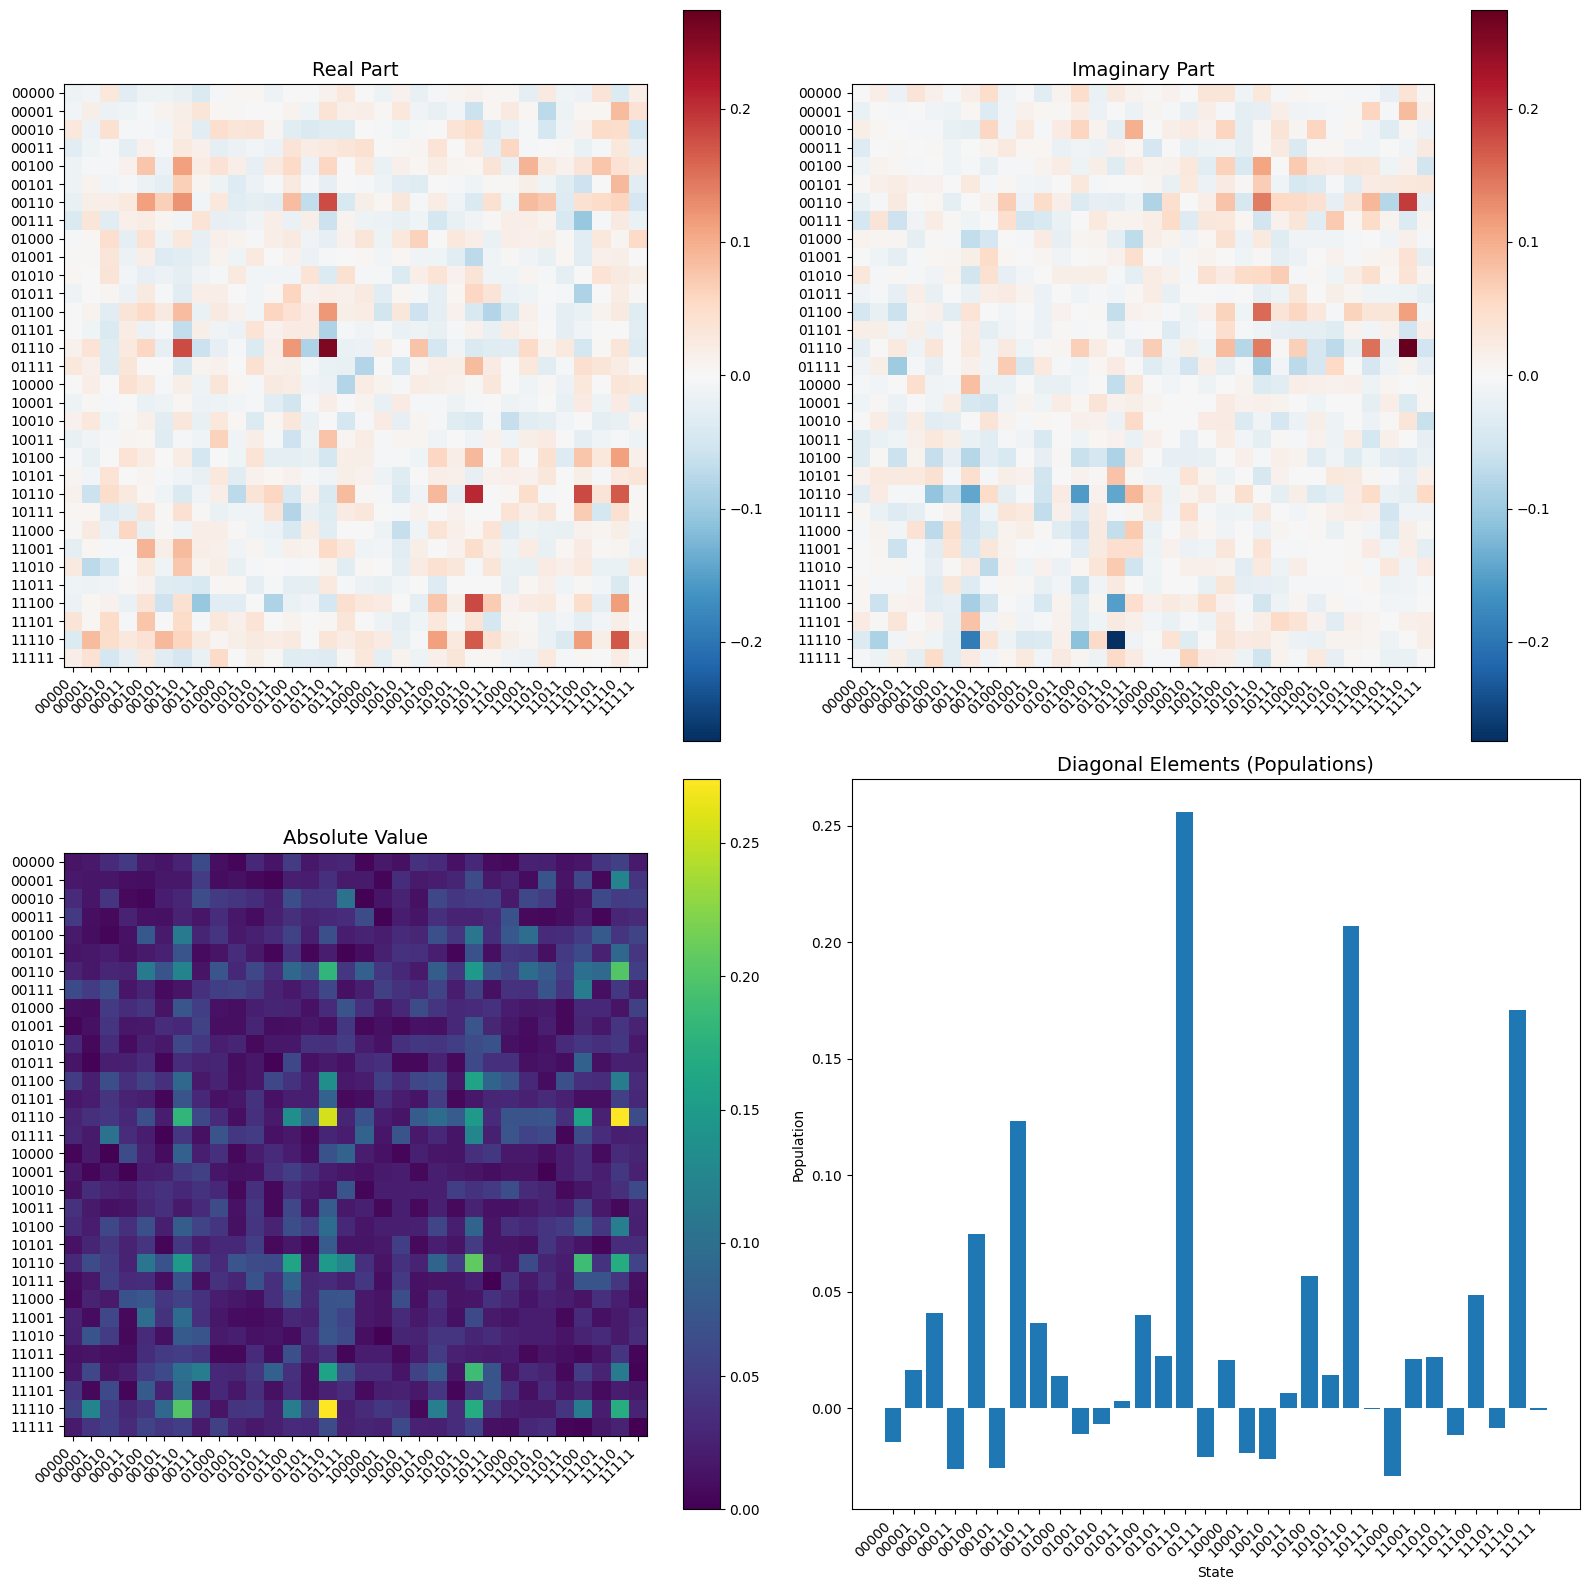

In [8]:
from utils import visualize_density_matrix
    
# Use the enhanced visualization
visualize_density_matrix(density_matrix, n_qubits)

## Toffoli gate teleportation

### Gate teleportation

In [11]:
import pennylane as qml
import numpy as np

# Get matrix for toffoli gate
def get_toffoli_matrix():
    return np.array(qml.Toffoli(wires=[0,1,2]).matrix())

X0 = qml.PauliX(0)
Z0 = qml.PauliZ(0)
X1 = qml.PauliX(1)
Z1 = qml.PauliZ(1)
X2 = qml.PauliX(2)
Z2 = qml.PauliZ(2)
I0 = qml.Identity(0)
I1 = qml.Identity(1)
I2 = qml.Identity(2)

basis = [Z0 @ I1 @ I2, 
        I0 @ Z1 @ I2,
        I0 @ I1 @ Z2,
        X0 @ I1 @ I2,
        I0 @ X1 @ I2,
        I0 @ I1 @ X2]

results = []
for b in basis:
    results.append(get_toffoli_matrix() @ b.matrix() @ get_toffoli_matrix())
    
pauli_decomposed = []

for result in results:
    pauli_decomposed.append(qml.pauli_decompose(result, wire_order=[6, 7, 8]))
    
hamiltonians = []

for p in pauli_decomposed:
    print(p.coeffs, p.ops)

# Braket and qiskit aer are able to visualize the decompositions
#dev = qml.device("braket.local.qubit", wires=[6, 7, 8], shots=1)
#dev = qml.device("qiskit.aer", wires=[6, 7, 8], shots=1)
dev = qml.device("default.qubit", wires=[6, 7, 8], shots=1)

#@qml.qnode(dev)
#def circuit(p):
#    hamiltonian = qml.Hamiltonian(p.coeffs, p.ops)
#    if len(p.coeffs) == 1:
#        qml.exp(hamiltonian, num_steps=1, coeff=1j)
#    else:
#        qml.exp(hamiltonian, num_steps=1, coeff=1j)
#    return qml.sample()

#for i, p in enumerate(pauli_decomposed):
#    qml.draw_mpl(circuit, expansion_strategy="device", show_all_wires=True, decimals=1)(p)

[1.] [Z(6) @ I(7) @ I(8)]
[1.] [I(6) @ Z(7) @ I(8)]
[ 0.5  0.5  0.5 -0.5] [I(6) @ I(7) @ Z(8), I(6) @ Z(7) @ Z(8), Z(6) @ I(7) @ Z(8), Z(6) @ Z(7) @ Z(8)]
[ 0.5  0.5  0.5 -0.5] [X(6) @ I(7) @ I(8), X(6) @ I(7) @ X(8), X(6) @ Z(7) @ I(8), X(6) @ Z(7) @ X(8)]
[ 0.5  0.5  0.5 -0.5] [I(6) @ X(7) @ I(8), I(6) @ X(7) @ X(8), Z(6) @ X(7) @ I(8), Z(6) @ X(7) @ X(8)]
[1.] [I(6) @ I(7) @ X(8)]


(<Figure size 1500x400 with 1 Axes>, <Axes: >)

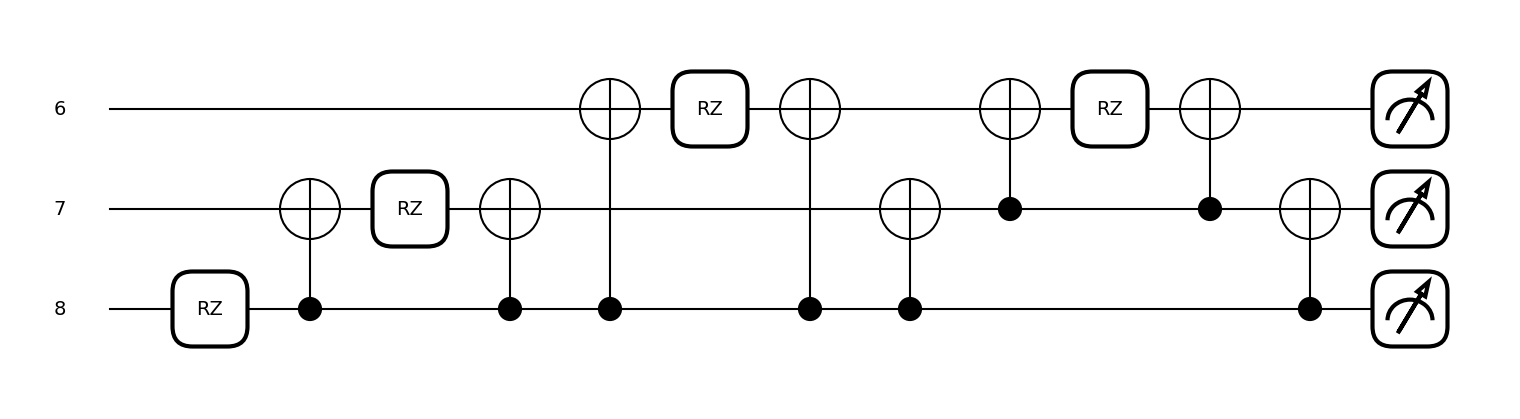

In [12]:
from utils import controlled_circuit1, controlled_circuit2, controlled_circuit3, controlled_circuit4, controlled_circuit5

# To visualize and debug the circuits
@qml.qnode(dev)
def circuit2():
    controlled_circuit2(np.pi/2)
    return qml.sample()

qml.draw_mpl(circuit2)()

In [13]:
dev = qml.device("default.qubit", wires=[0, 1, 2, 3, 4, 5, 6, 7, 8])
values = np.random.rand(9)

def bell_pair(source, target):
    qml.Hadamard(wires=source)
    qml.CNOT(wires=[source, target])
    
def bell_measurement(source, target):
    qml.CNOT(wires=[source, target])
    qml.Hadamard(wires=source)

@qml.qnode(dev)
def toffoli_teleportation():
    # Prepare the random input state for Toffoli gate
    
    qml.Rot(values[0], values[1], values[2], wires=0)
    qml.Rot(values[3], values[4], values[5], wires=1)
    qml.Rot(values[6], values[7], values[8], wires=2)
    
    # Prepare Bell pairs
    bell_pair(3, 6)
    bell_pair(4, 7)
    bell_pair(5, 8)
    
    #Prepare the Bell measurement
    bell_measurement(0, 3)
    bell_measurement(1, 4)
    bell_measurement(2, 5)
    
    # Perform the Toffoli gate on the output qubits
    qml.Toffoli(wires=[6, 7, 8])
    
    # Perform the Bell measurement
    m0 = qml.measure([0], reset=True)
    m1 = qml.measure([1], reset=True)
    m2 = qml.measure([2], reset=True)
    a0 = qml.measure([3], reset=True)
    a1 = qml.measure([4], reset=True)
    a2 = qml.measure([5], reset=True)
    
    glob_coeff = np.pi/2
    qml.cond(m0, controlled_circuit1)([6], coeff=2*glob_coeff)
    qml.cond(m1, controlled_circuit1)([7], coeff=2*glob_coeff)
    qml.cond(m2, controlled_circuit2)(coeff=glob_coeff)
    qml.cond(a0, controlled_circuit3)(coeff=glob_coeff)
    qml.cond(a1, controlled_circuit4)(coeff=glob_coeff)
    qml.cond(a2, controlled_circuit5)(coeff=2*glob_coeff)
    
    return qml.density_matrix(wires=[6, 7, 8])

(<Figure size 7200x1200 with 1 Axes>, <Axes: >)

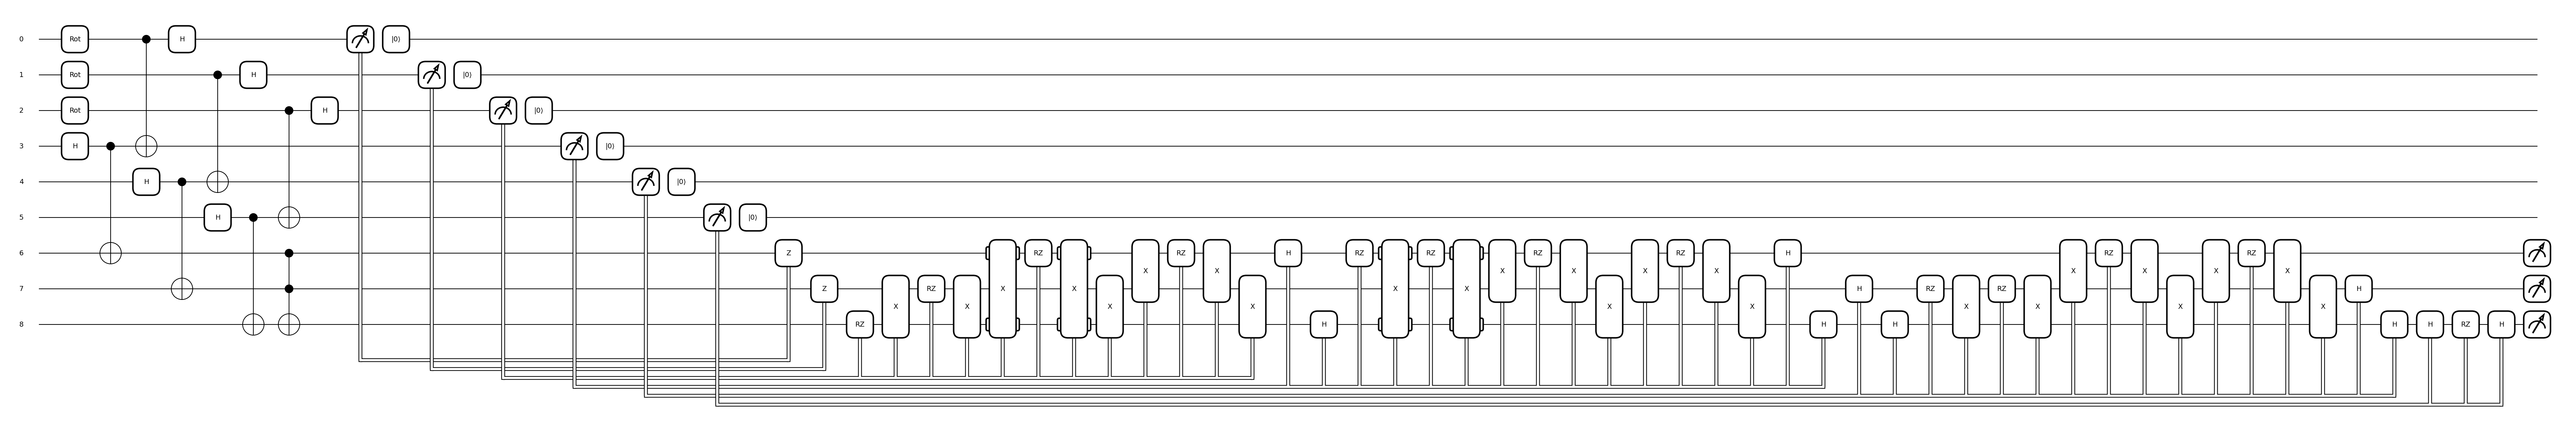

In [14]:
qml.draw_mpl(toffoli_teleportation)()

In [17]:
results = toffoli_teleportation()

dev = qml.device("default.qubit", wires=[0, 1, 2])
@qml.qnode(dev)
def toffoli_teleportation2():
    qml.Rot(values[0], values[1], values[2], wires=0)
    qml.Rot(values[3], values[4], values[5], wires=1)
    qml.Rot(values[6], values[7], values[8], wires=2)
    qml.Toffoli(wires=[0, 1, 2])
    return qml.density_matrix(wires=[0, 1, 2])

#print(toffoli_teleportation2())

# Compare that the density matrix from the teleportation circuit is 
# the same as the one when the Toffoli gate is applied directly
print(np.allclose(results, toffoli_teleportation2()))

True


## Measurements as solutions to quantum computational challenges

1. Quantum error mitigation
2. Circuit cutting



## Conclusion and future work

1. This paper contains only a small subset of measurement operations that are used and thus this work should be extended. For example, we left out:
    1. Error-correcting codes
    2. Measurement-based quantum computing
    3. Hidden parameter extraction
2. Measurement is not only a passive operation at the end